In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import neurokit2 as nk
import matplotlib.pyplot as plt

# Global settings
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (20, 6)
plt.style.use('ggplot') # nicer plots
pd.set_option('display.max_columns', None)

# Data loading
df = pd.read_csv('output/empatica_inquisit_merged.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

# Create a dictionary that maps the original filenames to the new filenames
filename_map = {
    'd1 2': 'pp15_d1 2',
    'd1_1': 'pp13_d1_1',
    '1681713254_A03F6E': 'pp16_1681713254_A03F6E',
    '1681717717_A03F6E': 'pp17_1681717717_A03F6E',
    'd1_3': 'pp18_d1_3',
    'd2_1_1': 'pp17_d2_1_1',
    'd2_2': 'pp16_d2_2',
    'd1': 'pp19_d1',
    'd1_4': 'pp20_d1_4',
    'd2': 'pp18_d2',
    'd2_1': 'pp19_d2_1',
    'd2_4': 'pp20_d2_4'
}

# Update the 'source' column
df['source'] = df['source'].replace(filename_map)

df['participant'] = df['source'].str.extract('pp(\d{1,2})').astype(float)

# Rename values for participant to be incremental integers starting from 1
df['participant'] = df['participant'].replace({3: 1, 2: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 15: 12, 16: 13, 17: 14, 18: 15, 19: 16, 20: 17})

# Turn to int
df['participant'] = df['participant'].astype(int)

/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_90414/2495836409.py:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('output/empatica_inquisit_merged.csv')


In [68]:
# Filtering 
df['eda'] = nk.eda_clean(df['eda'], sampling_rate=64, method='biosppy')
df['bvp'] = nk.ppg_clean(df['bvp'], sampling_rate=64, heart_rate=None, method='elgendi')

# Calculate body acceleration
df['body_acc'] = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)

# Drop acc columns
df = df.drop(columns=['acc_x', 'acc_y', 'acc_z'])

In [69]:
# Print missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

hr                        576
trialcode            12410614
intrusion_nothink    12411914
intrusion_tnt        12410614
dtype: int64


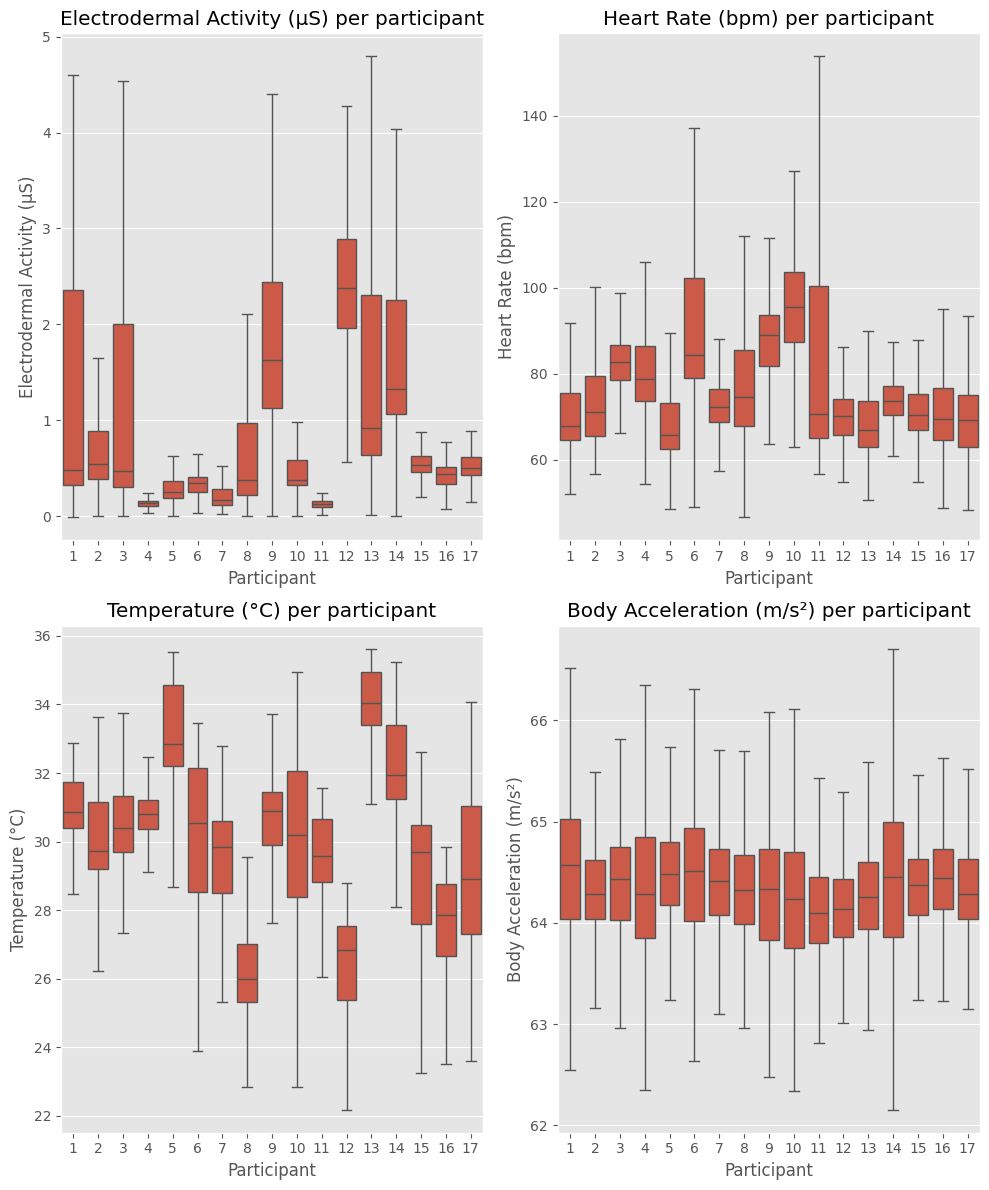

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["eda", "hr", "temp", "body_acc"]

feature_dict = {
    "eda" : "Electrodermal Activity (µS)",
    "bvp" : "Blood Volume Pulse (a.u.)",
    "temp" : "Temperature (°C)",
    "body_acc" : "Body Acceleration (m/s²)",
    "hr" : "Heart Rate (bpm)"
}

fig, axs = plt.subplots(2, 2, figsize=(10, 12))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    sns.boxplot(x='participant', y=feature, data=df, ax=axs[row, col], showfliers=False)
    axs[row, col].set_title(feature_dict[feature] + " per participant")
    axs[row, col].set_xlabel("Participant")
    axs[row, col].set_ylabel(feature_dict[feature])

plt.tight_layout()
plt.show()

In [4]:
df.head()

,temp,eda,bvp,hr,datetime,unix_time,source,trialcode,response,intrusion,intrusion_nothink,intrusion_tnt,participant,body_acc
0,26.45,0.03,-13.25,85.00,2023-03-22 12:05:18.000000,1679486718.00,pp3-d1-1,NaN,0,0,NaN,NaN,1,66.96
1,26.47,0.03,8.58,84.98,2023-03-22 12:05:18.015625,1679486718.02,pp3-d1-1,NaN,0,0,NaN,NaN,1,69.41
2,26.48,0.03,21.11,84.95,2023-03-22 12:05:18.031250,1679486718.03,pp3-d1-1,NaN,0,0,NaN,NaN,1,66.04
3,26.49,0.03,18.63,84.92,2023-03-22 12:05:18.046875,1679486718.05,pp3-d1-1,NaN,0,0,NaN,NaN,1,61.75
4,26.50,0.03,1.06,84.88,2023-03-22 12:05:18.062500,1679486718.06,pp3-d1-1,NaN,0,0,NaN,NaN,1,61.92


In [62]:
from sklearn.preprocessing import StandardScaler

columns_to_normalize = ["body_acc", "temp", "eda", "bvp", "hr"]
participants = df['participant']

# Apply StandardScaler to each participant group and avoid resetting the index
scaled_df = df.groupby(participants)[columns_to_normalize].apply(lambda x: pd.DataFrame(StandardScaler().fit_transform(x), columns=x.columns) if len(x) > 1 else x)

# Reset the inner level of the index
scaled_df.reset_index(drop=True, inplace=True)

# Merge the scaled data back into the original dataframe
df[columns_to_normalize] = scaled_df

print(df.head(50))

    temp   eda   bvp   hr                   datetime     unix_time    source  \
0  -1.45 -0.96 -0.20 0.96 2023-03-22 12:05:18.000000 1679486718.00  pp3-d1-1   
1  -1.45 -0.96  0.13 0.96 2023-03-22 12:05:18.015625 1679486718.02  pp3-d1-1   
2  -1.44 -0.96  0.32 0.96 2023-03-22 12:05:18.031250 1679486718.03  pp3-d1-1   
3  -1.44 -0.96  0.28 0.96 2023-03-22 12:05:18.046875 1679486718.05  pp3-d1-1   
4  -1.43 -0.96  0.02 0.95 2023-03-22 12:05:18.062500 1679486718.06  pp3-d1-1   
5  -1.43 -0.96 -0.40 0.95 2023-03-22 12:05:18.078125 1679486718.08  pp3-d1-1   
6  -1.43 -0.96 -0.85 0.95 2023-03-22 12:05:18.093750 1679486718.09  pp3-d1-1   
7  -1.43 -0.96 -1.19 0.94 2023-03-22 12:05:18.109375 1679486718.11  pp3-d1-1   
8  -1.43 -0.96 -1.34 0.94 2023-03-22 12:05:18.125000 1679486718.12  pp3-d1-1   
9  -1.43 -0.96 -1.28 0.93 2023-03-22 12:05:18.140625 1679486718.14  pp3-d1-1   
10 -1.43 -0.96 -1.04 0.93 2023-03-22 12:05:18.156250 1679486718.16  pp3-d1-1   
11 -1.43 -0.96 -0.73 0.92 2023-03-22 12:

## Visualising windows preceding + or - class labels

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df['unix_time'] = pd.to_datetime(df['unix_time'], unit='s')  # Convert 'unix_time' to datetime format
df = df.set_index('unix_time')

def get_segment_data(df, column_names):
    """
    Extracts segment data from a DataFrame based on specified column names.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        column_names (list): A list of column names to extract segment data from.

    Returns:
        tuple: A tuple containing two dictionaries. The first dictionary contains segment data for positive labels,
               and the second dictionary contains segment data for negative labels. Each dictionary maps column names
               to DataFrames, where each column in the DataFrame represents an 8-second window of data.

    """
    # Initialize dictionaries to store data for each label
    positive_data = {}
    negative_data = {}

    # Identify the indices where 'intrusion_tnt' is 1 and 0
    positive_indices = df[df['intrusion_tnt'] == 1].index
    negative_indices = df[df['intrusion_tnt'] == 0].index

    # For each column name
    for column in column_names:
        # Initialize lists to store data for each label
        positive_column_data = []
        negative_column_data = []

        # For each positive index, get the 8s preceding data
        for idx in positive_indices:
            temp_data = df.loc[idx - pd.Timedelta(seconds=8) + pd.Timedelta(seconds=1/64):idx, column]
            temp_data = temp_data.reset_index(drop=True)
            
            temp_data.name = f"{idx}"
            positive_column_data.append(temp_data)

        # For each negative index, get the 8s preceding data
        for idx in negative_indices:
            temp_data = df.loc[idx - pd.Timedelta(seconds=8) + pd.Timedelta(seconds=1/64):idx, column]
            temp_data = temp_data.reset_index(drop=True)
            temp_data.name = f"{idx}"
            negative_column_data.append(temp_data)

        # Concatenate the list of 8s of data into a DataFrame where each column is an 8s window of data
        positive_data[column] = pd.concat(positive_column_data, axis=1)
        negative_data[column] = pd.concat(negative_column_data, axis=1)

    return positive_data, negative_data

positive_data, negative_data = get_segment_data(df, ["body_acc", "temp", "eda", "bvp", "hr"])

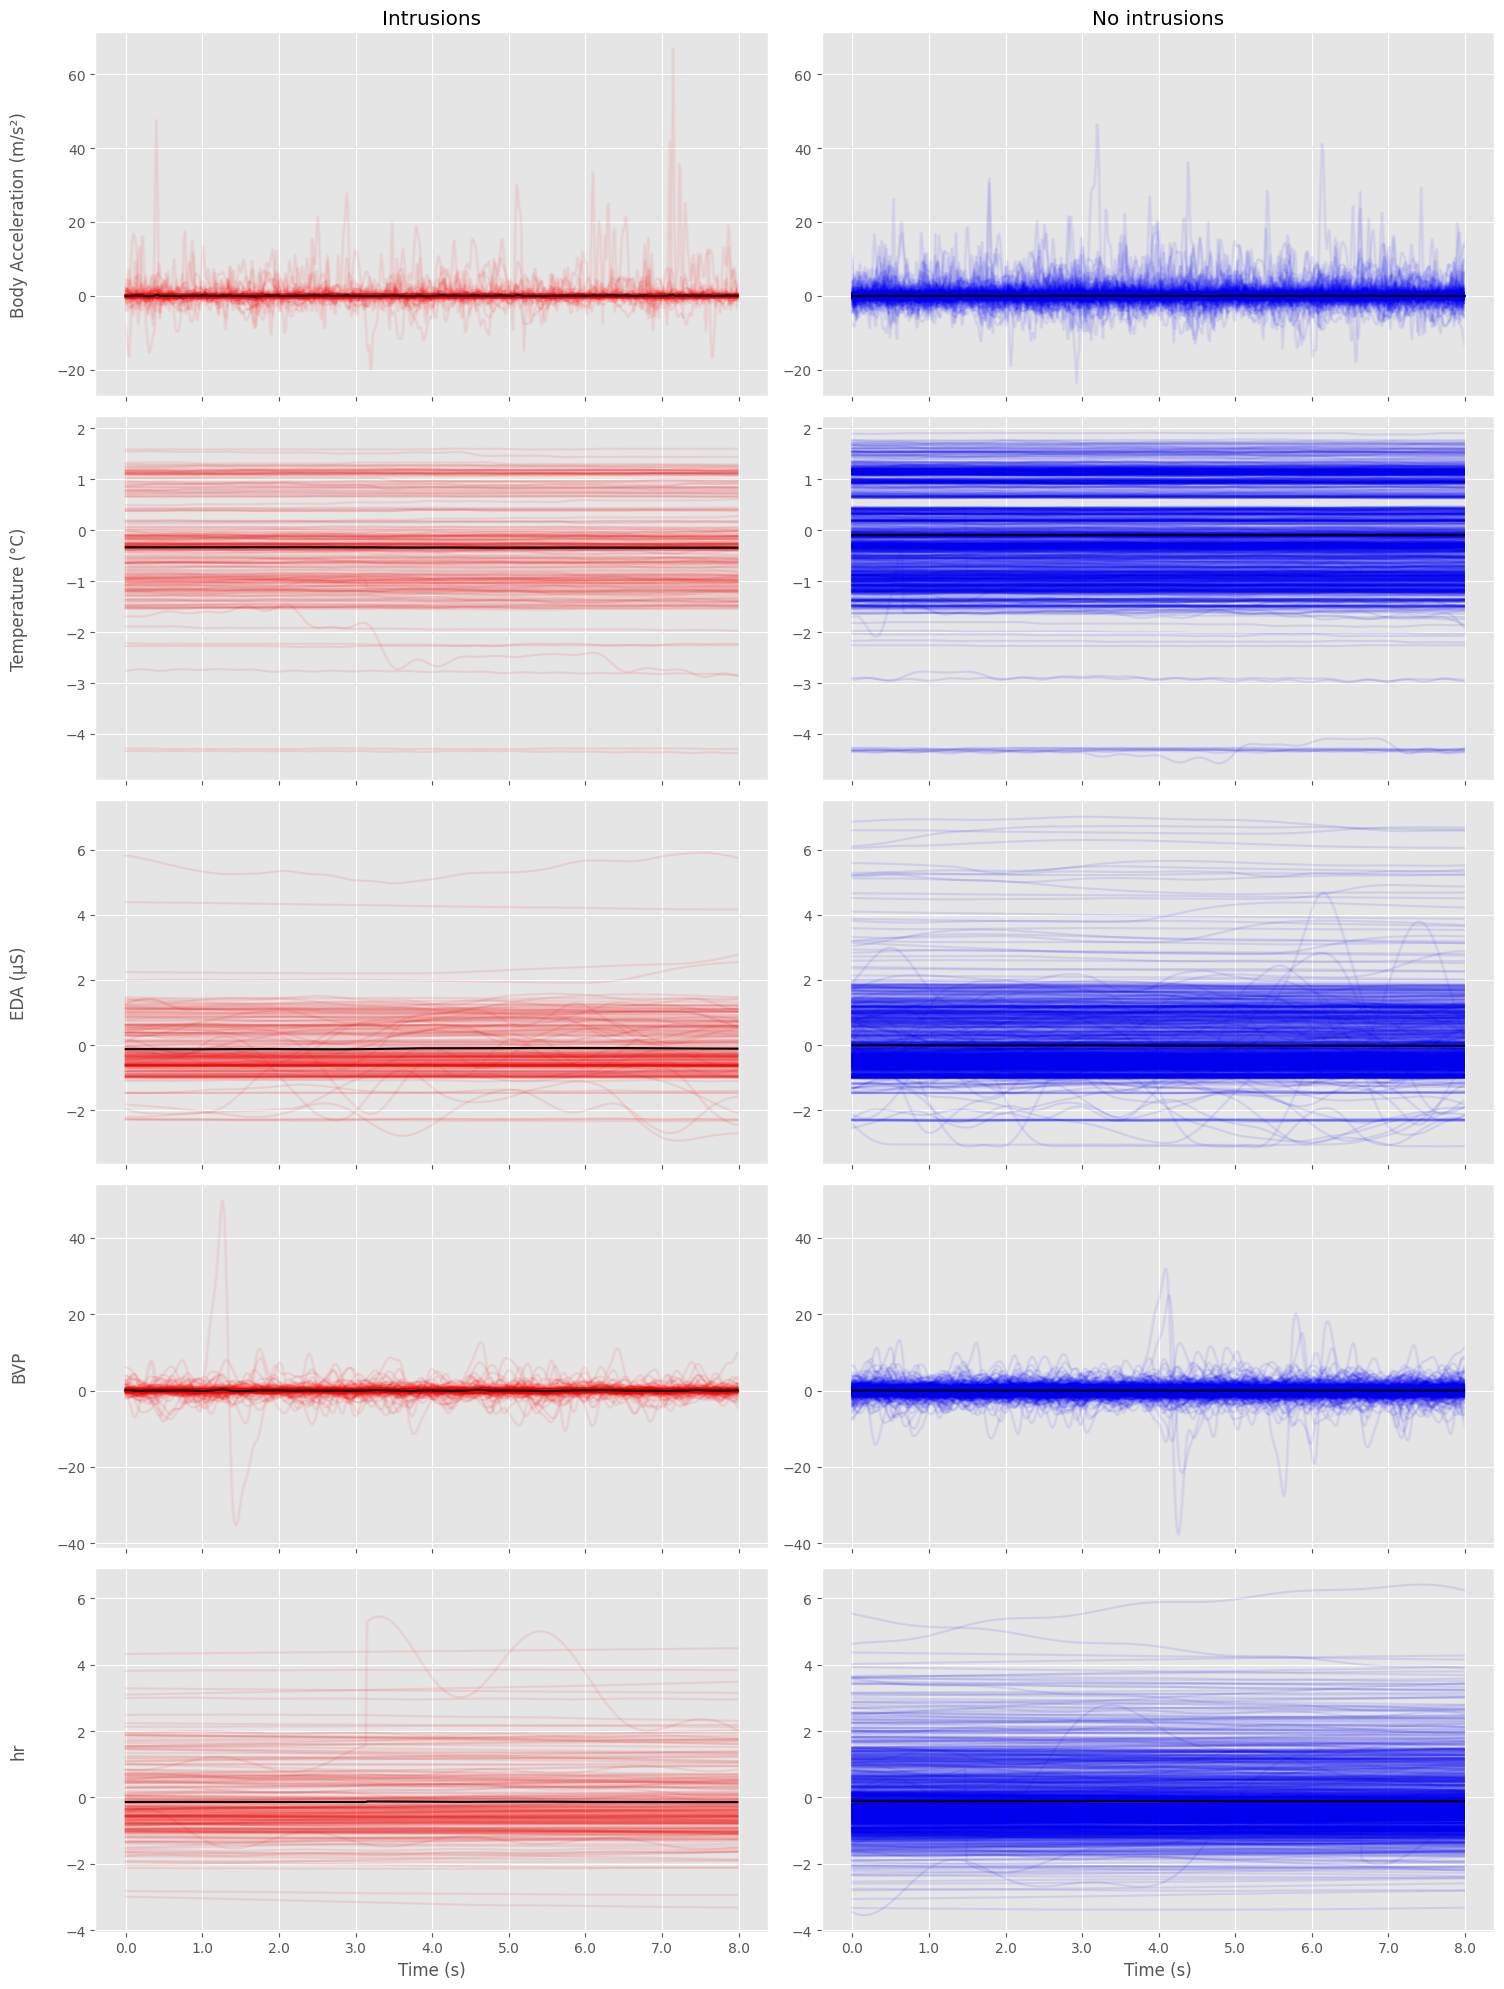

In [11]:
def plot_data_grid(positive_data, negative_data, save=False):
    """
    Plots the data grid for positive and negative data.

    Parameters:
    positive_data (dict): A dictionary containing positive data for each key.
    negative_data (dict): A dictionary containing negative data for each key.
    save (bool, optional): Whether to save the plot as an image. Defaults to False.

    Returns:
    None
    """
    # Create a grid of subplots with as many rows as there are keys in the data and 2 columns (one for each label)
    fig, axs = plt.subplots(len(positive_data.keys()), 2, sharex=True, figsize=(15, 4 * len(positive_data.keys())))

    # Create a time array based on the sampling rate
    time = np.arange(0, len(next(iter(positive_data.values())).iloc[:,0])) / 64

    # Create a dictionary to map old labels to new ones
    label_map = {
        'bvp': 'BVP',
        'eda': 'EDA (μS)',
        'temp': 'Temperature (°C)',
        'acc_x': 'Acceleration (x-axis)',
        'acc_y': 'Acceleration (y-axis)',
        'acc_z': 'Acceleration (z-axis)',
        'body_acc': 'Body Acceleration (m/s²)',
    }

    # For each key in the data
    for i, key in enumerate(positive_data.keys()):
        # Plot positive data
        for column in positive_data[key].columns:
            sns.lineplot(x=time, y=positive_data[key][column], alpha=0.05, color='red', ax=axs[i, 0])
        sns.lineplot(x=time, y=positive_data[key].mean(axis=1), color='black', ax=axs[i, 0])
        axs[i, 0].set_ylabel(label_map.get(key, key))  # Use the new label if it exists, otherwise use the old one
        axs[i, 0].yaxis.set_label_coords(-0.1,0.5)  # Set y-axis label coordinates
        axs[i, 0].set_xlabel('Time (s)')
        axs[i, 0].set_xticks(np.arange(min(time), max(time)+1, 1))  # Set x-axis ticks
        axs[i, 0].set_xticklabels(np.arange(min(time), max(time)+1, 1))  # Set x-axis tick labels

        # Plot negative data
        for column in negative_data[key].columns:
            sns.lineplot(x=time, y=negative_data[key][column], alpha=0.05, color='blue', ax=axs[i, 1])
        sns.lineplot(x=time, y=negative_data[key].mean(axis=1), color='black', ax=axs[i, 1])
        axs[i, 1].set_xlabel('Time (s)')
        axs[i, 1].set_ylabel('')  # Remove y-axis title for the second column
        axs[i, 1].set_xticks(np.arange(min(time), max(time)+1, 1))  # Set x-axis ticks
        axs[i, 1].set_xticklabels(np.arange(min(time), max(time)+1, 1))  # Set x-axis tick labels

        # Make y-axis the same for both plots in the row
        min_y = min(axs[i, 0].get_ylim()[0], axs[i, 1].get_ylim()[0])
        max_y = max(axs[i, 0].get_ylim()[1], axs[i, 1].get_ylim()[1])
        axs[i, 0].set_ylim(min_y, max_y)
        axs[i, 1].set_ylim(min_y, max_y)

    # Set column titles
    axs[0, 0].set_title('Intrusions')
    axs[0, 1].set_title('No intrusions')

    # Show the plot
    plt.tight_layout()
    if save:
        plt.savefig('output/pos_neg_classwindow_feature_values.png', dpi=300)
    plt.show()

plot_data_grid(positive_data, negative_data, save=True)

In [104]:
df['unix_time'] = pd.to_datetime(df['unix_time'], unit='s')  # Convert 'unix_time' to datetime format
df = df.set_index('unix_time')

def get_segment_data_per_participant(df, column_names):
    """
    Extracts segment data from a DataFrame based on specified column names.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        column_names (list): A list of column names to extract segment data from.

    Returns:
        tuple: A tuple containing two dictionaries. The first dictionary contains segment data for positive labels,
               and the second dictionary contains segment data for negative labels. Each dictionary maps participant names
               to another dictionary, which maps column names to DataFrames, where each column in the DataFrame represents 
               an 8-second window of data.
    """
    # Initialize dictionaries to store data for each label
    positive_data = {}
    negative_data = {}

    # Identify the indices where 'intrusion_tnt' is 1 and 0
    positive_indices = df[df['intrusion_tnt'] == 1].index
    negative_indices = df[df['intrusion_tnt'] == 0].index

    # Get unique participants
    participants = df['participant'].unique()

    # For each participant
    for participant in participants:
        # Initialize dictionaries to store data for each column
        positive_data[participant] = {}
        negative_data[participant] = {}

        # For each column name
        for column in column_names:
            # Initialize lists to store data for each label
            positive_column_data = []
            negative_column_data = []

            # For each positive index, get the 8s preceding data
            for idx in positive_indices:
                if df.loc[idx, 'participant'] == participant:
                    temp_data = df.loc[idx - pd.Timedelta(seconds=8) + pd.Timedelta(seconds=1/64):idx, column]
                    temp_data = temp_data.reset_index(drop=True)
                    temp_data.name = f"{idx}"
                    positive_column_data.append(temp_data)

            # For each negative index, get the 8s preceding data
            for idx in negative_indices:
                if df.loc[idx, 'participant'] == participant:
                    temp_data = df.loc[idx - pd.Timedelta(seconds=8) + pd.Timedelta(seconds=1/64):idx, column]
                    temp_data = temp_data.reset_index(drop=True)
                    temp_data.name = f"{idx}"
                    negative_column_data.append(temp_data)

            # Concatenate the list of 8s of data into a DataFrame where each column is an 8s window of data
            if positive_column_data:
                positive_data[participant][column] = pd.concat(positive_column_data, axis=1)
            if negative_column_data:
                negative_data[participant][column] = pd.concat(negative_column_data, axis=1)

    return positive_data, negative_data

positive_data, negative_data = get_segment_data_per_participant(df, ["body_acc", "temp", "eda", "bvp", "hr"])

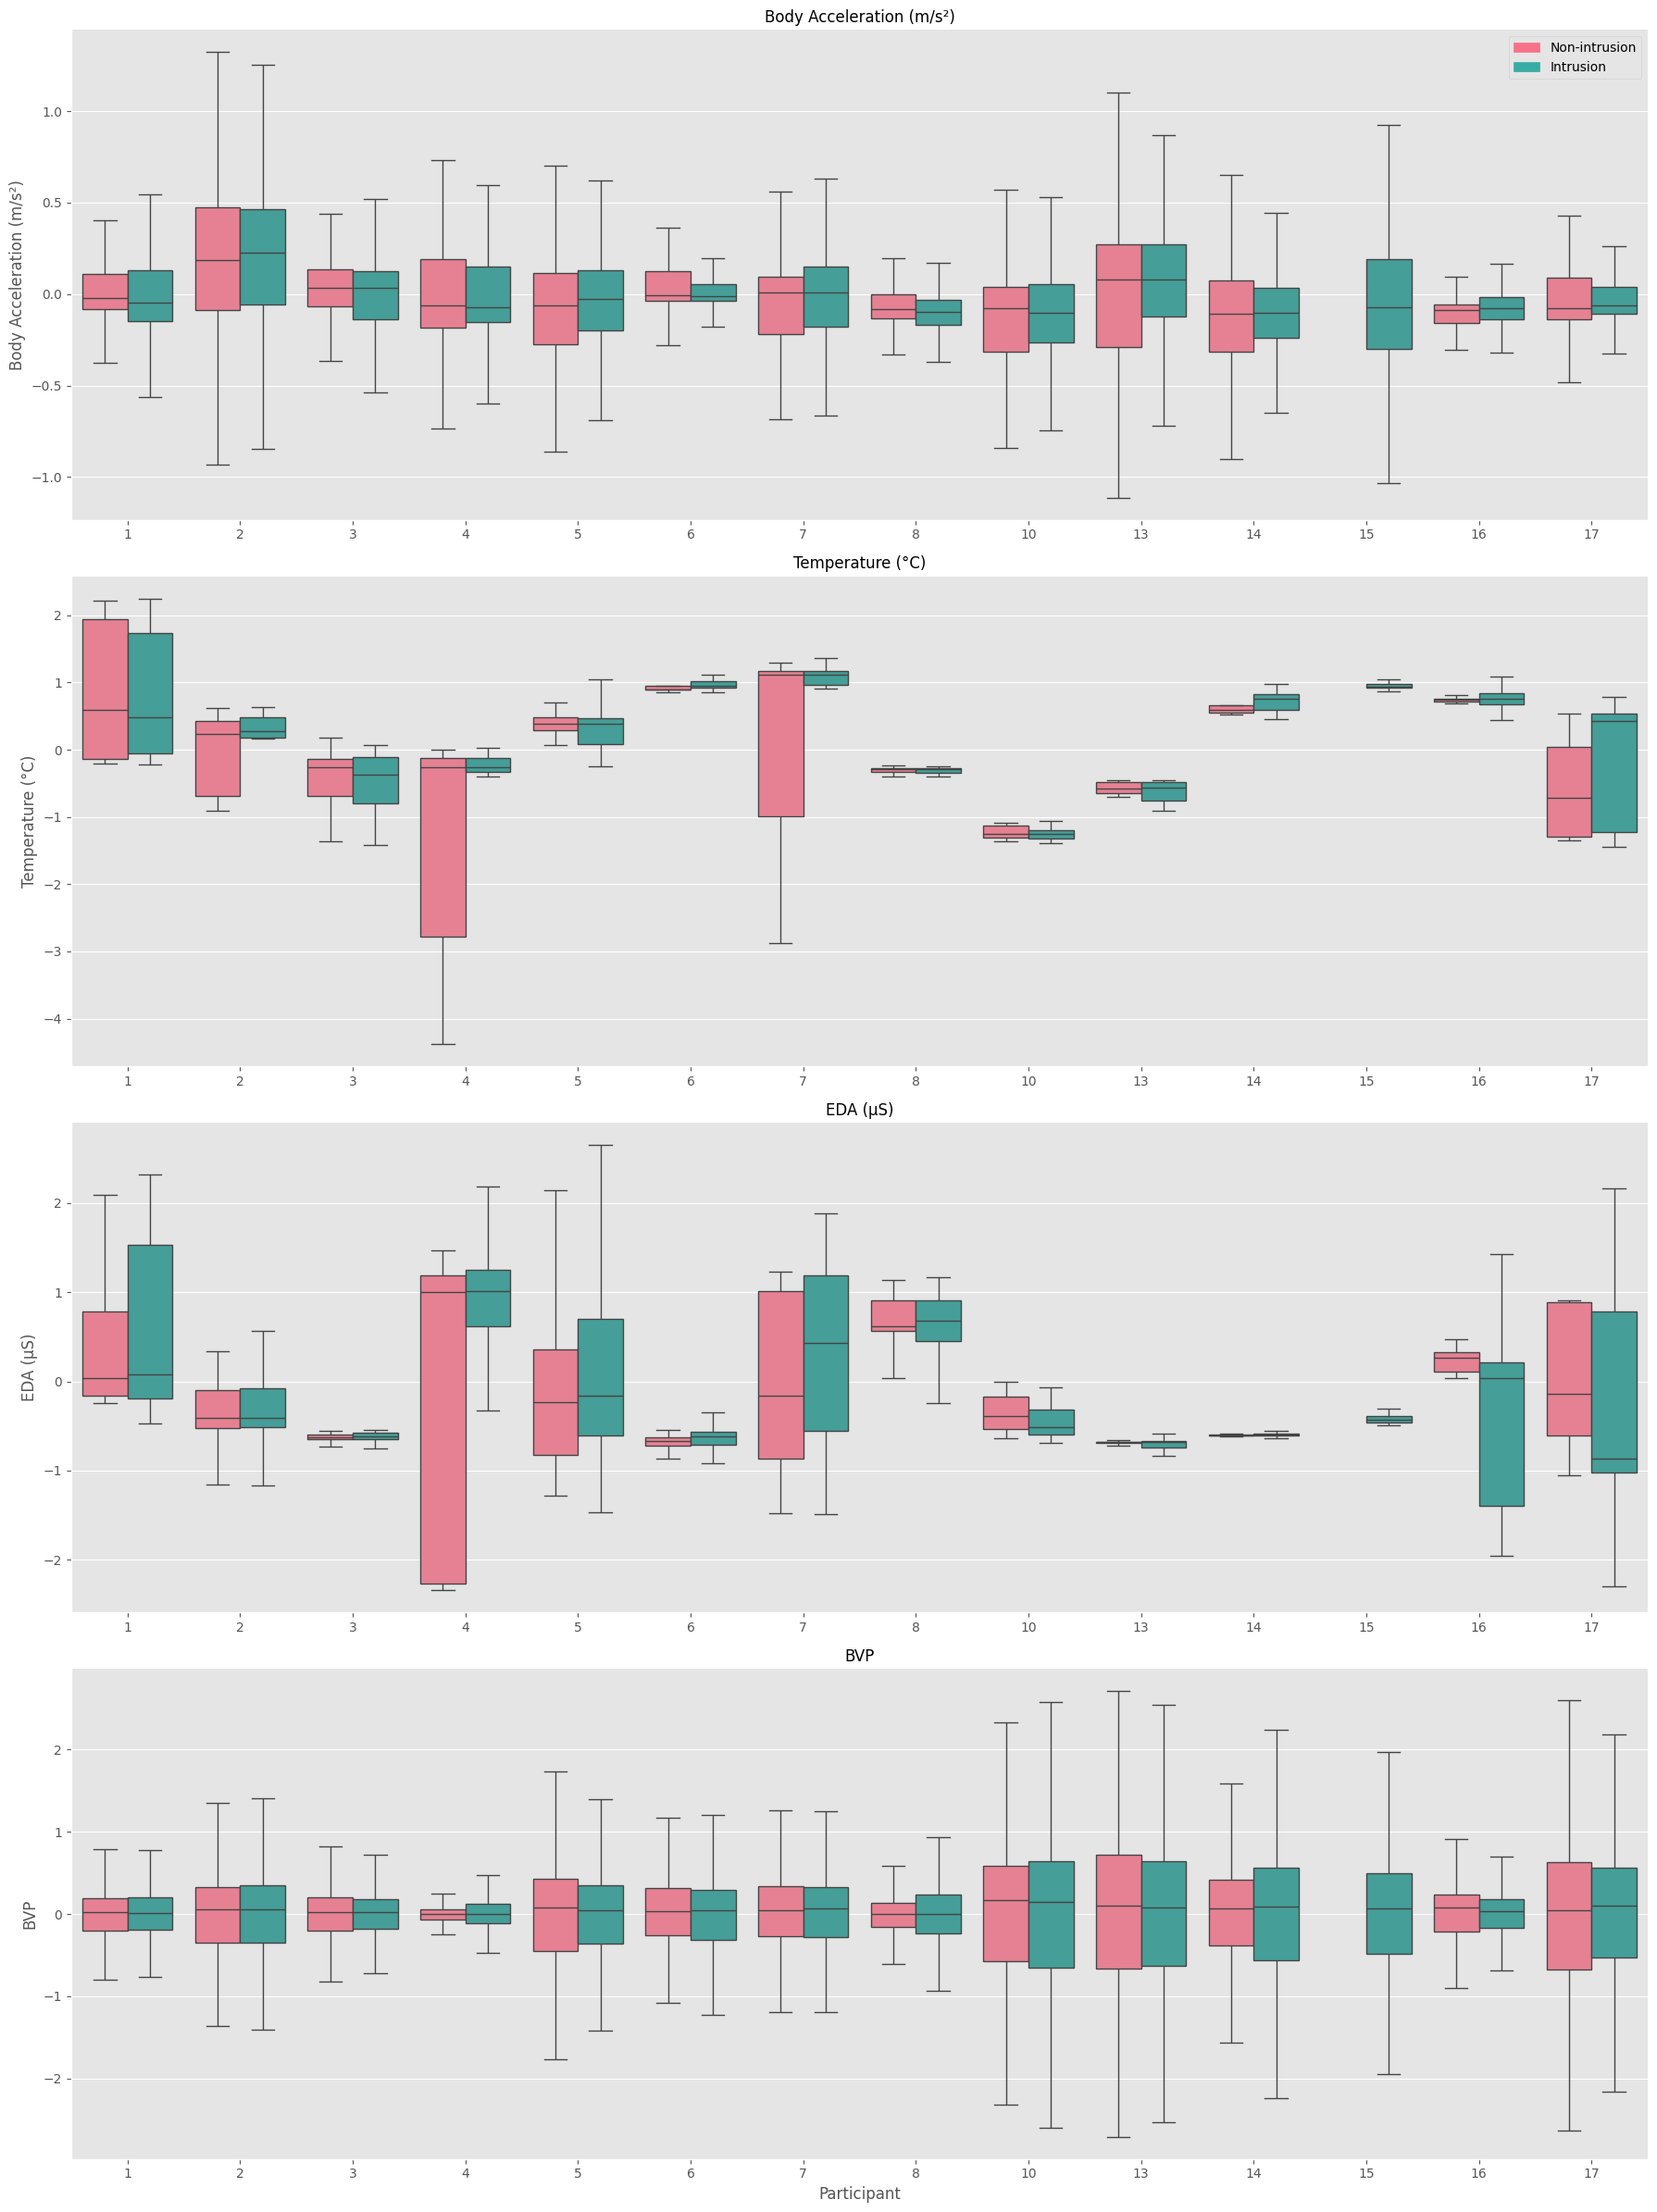

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Create a dictionary to map old labels to new ones
label_map = {
    'bvp': 'BVP',
    'eda': 'EDA (μS)',
    'temp': 'Temperature (°C)',
    'acc_x': 'Acceleration (x-axis)',
    'acc_y': 'Acceleration (y-axis)',
    'acc_z': 'Acceleration (z-axis)',
    'body_acc': 'Body Acceleration (m/s²)',
}

# Step 1: Transform the data to long format
data = []
for label, dataset in [("Positive", positive_data), ("Negative", negative_data)]:
    for participant, participant_data in dataset.items():
        for column, column_data in participant_data.items():
            for value in column_data.values.flatten():
                data.append([participant, column, label, value])
df_long = pd.DataFrame(data, columns=["Participant", "Feature", "Label", "Value"])

# Map old labels to new ones
df_long["Feature"] = df_long["Feature"].map(label_map)

# Step 2: Create a FacetGrid
g = sns.FacetGrid(df_long, row="Feature", sharex=False, sharey=False, height=6, aspect=3)

# Define the colors for the boxplots
colors = sns.color_palette('husl', n_colors=2)

# Step 3: Map a boxplot to each facet
def boxplot(x, y, hue, **kwargs):
    ax = sns.boxplot(x=x, y=y, hue=hue, palette=colors, **kwargs)
    ax.legend().remove()  # Remove the legend after creating the boxplot

g.map(boxplot, "Participant", "Value", "Label", showfliers=False)

# Create patches for the legend
non_intrusion_patch = mpatches.Patch(color=colors[0], label='Non-intrusion')
intrusion_patch = mpatches.Patch(color=colors[1], label='Intrusion')

# Add the legend back only for the first subplot
g.axes[0,0].legend(handles=[non_intrusion_patch, intrusion_patch], loc='upper right')

# Adjust the layout
g.set_titles("{row_name}")
g.set_ylabels("")  # Remove default y-labels
for ax, title in zip(g.axes.flat, g.row_names):
    ax.set_ylabel(title)  # Set y-labels to be the feature name

plt.tight_layout()

# Show the plot
plt.show()

To calculate rolling windows for periods that are actually consecutive, you can use the rolling function in combination with the groupby function.

First, you need to create a new column that identifies each separate session. This could be done based on the datetime column. For example, you could consider that a new session starts when the time difference with the previous measurement is more than a certain threshold.

Once you have a column that identifies the sessions, you can group by this column and then apply the rolling function to each group. This will ensure that the rolling windows are calculated separately for each session.

In [63]:
# Create a column 'session_id' that identifies each session
df['session_id'] = (df['datetime'].diff() > pd.Timedelta(seconds=1/64)).cumsum()

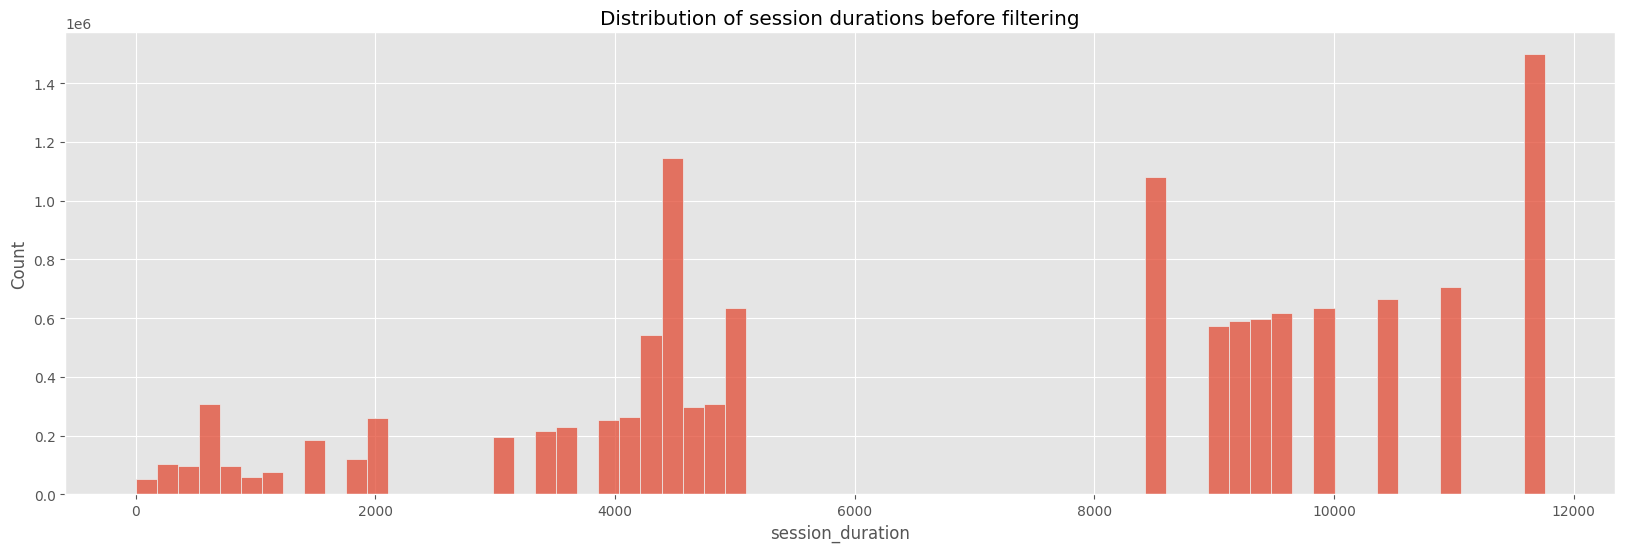

Number of sessions before filtering: 67
Number of sessions after filtering: 63


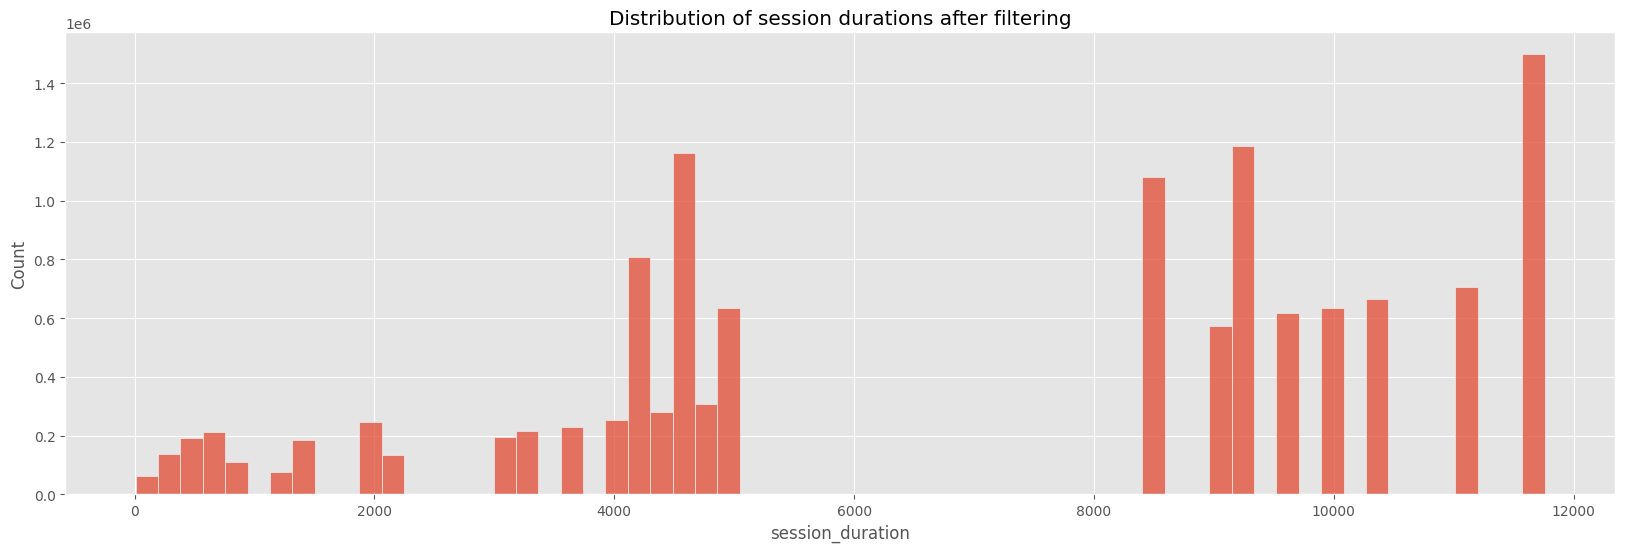

In [64]:
# Create a column 'session_duration' that indicates the duration of each session
df['session_duration'] = df.groupby('session_id')['datetime'].transform(lambda x: x.max() - x.min())

# Create a column 'session_start' that indicates the start of each session
df['session_start'] = df.groupby('session_id')['datetime'].transform('first')

# Create a column 'session_end' that indicates the end of each session
df['session_end'] = df.groupby('session_id')['datetime'].transform('last')

# Plot the distribution of session durations
sns.histplot(df['session_duration'].dt.total_seconds(), bins=len(df['session_id'].unique()))
plt.title('Distribution of session durations before filtering')
plt.show()

# Drop all sessions that are shorter than 8 seconds
print(f"Number of sessions before filtering: {len(df['session_id'].unique())}")
df = df[df['session_duration'].dt.total_seconds() > 8]
print(f"Number of sessions after filtering: {len(df['session_id'].unique())}")

# Plot the distribution of session durations
sns.histplot(df['session_duration'].dt.total_seconds(), bins=len(df['session_id'].unique()))
plt.title('Distribution of session durations after filtering')
plt.show()

In [33]:
df.columns

Index(['temp', 'eda', 'bvp', 'hr', 'datetime', 'unix_time', 'source',
       'trialcode', 'response', 'intrusion', 'intrusion_nothink',
       'intrusion_tnt', 'participant', 'body_acc', 'session_id',
       'session_duration', 'session_start', 'session_end'],
      dtype='object')

In [65]:
s = 8 # Window size in seconds (8 seconds appears to be optimal based on theorising)
sr = 64
win = sr*s

# EDA
signals, info = nk.eda_process(df['eda'], sampling_rate=sr)
df['eda'] = signals['EDA_Clean'].values
df.drop(columns=['eda'])

df['eda_tonic'] = signals['EDA_Tonic'].values
df['eda_phasic'] = signals['EDA_Phasic'].values
# Remove the following features as they are not useful (>99% 0 values)
    # df['eda_scr_onsets'] = signals['SCR_Onsets'].values
    # df['eda_scr_peaks'] = signals['SCR_Peaks'].values
    # df['eda_scr_height'] = signals['SCR_Height'].values
    # df['eda_scr_amplitude'] = signals['SCR_Amplitude'].values
    # df['eda_scr_risetime'] = signals['SCR_RiseTime'].values
    # df['eda_scr_recovery'] = signals['SCR_Recovery'].values

# Group by 'session_id'
temp = df.groupby('session_id')

# EDA
# EDA Tonic
df['eda_tonic_mean'] = temp['eda_tonic'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_tonic_std'] = temp['eda_tonic'].rolling(window=win).std().reset_index(0, drop=True)
df['eda_tonic_min'] = temp['eda_tonic'].rolling(window=win).min().reset_index(0, drop=True)
df['eda_tonic_max'] = temp['eda_tonic'].rolling(window=win).max().reset_index(0, drop=True)
df['eda_tonic_skew'] = temp['eda_tonic'].rolling(window=win).skew().reset_index(0, drop=True)
df['eda_tonic_kurt'] = temp['eda_tonic'].rolling(window=win).kurt().reset_index(0, drop=True)

# EDA Phasic
df['eda_phasic_mean'] = temp['eda_phasic'].rolling(window=win).mean().reset_index(0, drop=True)
df['eda_phasic_std'] = temp['eda_phasic'].rolling(window=win).std().reset_index(0, drop=True)
df['eda_phasic_min'] = temp['eda_phasic'].rolling(window=win).min().reset_index(0, drop=True)
df['eda_phasic_max'] = temp['eda_phasic'].rolling(window=win).max().reset_index(0, drop=True)
df['eda_phasic_skew'] = temp['eda_phasic'].rolling(window=win).skew().reset_index(0, drop=True)
df['eda_phasic_kurt'] = temp['eda_phasic'].rolling(window=win).kurt().reset_index(0, drop=True)
# Remove the following features as they are not useful (>99% 0 values)
    # df['eda_scr_onsets_mean'] = temp['eda_scr_onsets'].rolling(window=win).mean().reset_index(0, drop=True)
    # df['eda_scr_peaks_sum'] = temp['eda_scr_peaks'].rolling(window=win).sum().reset_index(0, drop=True)
    # df['eda_scr_height_mean'] = temp['eda_scr_height'].rolling(window=win).mean().reset_index(0, drop=True)
    # df['eda_scr_amplitude_mean'] = temp['eda_scr_amplitude'].rolling(window=win).mean().reset_index(0, drop=True)
    # df['eda_scr_risetime_mean'] = temp['eda_scr_risetime'].rolling(window=win).mean().reset_index(0, drop=True)
    # df['eda_scr_recovery_mean'] = temp['eda_scr_recovery'].rolling(window=win).mean().reset_index(0, drop=True)

# ACCELEROMETER
df['body_acc_mean'] = temp['body_acc'].rolling(window=win).mean().reset_index(0, drop=True)
df['body_acc_std'] = temp['body_acc'].rolling(window=win).std().reset_index(0, drop=True)
df['body_acc_min'] = temp['body_acc'].rolling(window=win).min().reset_index(0, drop=True)
df['body_acc_max'] = temp['body_acc'].rolling(window=win).max().reset_index(0, drop=True)
df['body_acc_skew'] = temp['body_acc'].rolling(window=win).skew().reset_index(0, drop=True)
df['body_acc_kurt'] = temp['body_acc'].rolling(window=win).kurt().reset_index(0, drop=True)

# TEMPERATURE
df['temp_mean'] = temp['temp'].rolling(window=win).mean().reset_index(0, drop=True)
df['temp_std'] = temp['temp'].rolling(window=win).std().reset_index(0, drop=True)
df['temp_min'] = temp['temp'].rolling(window=win).min().reset_index(0, drop=True)
df['temp_max'] = temp['temp'].rolling(window=win).max().reset_index(0, drop=True)
df['temp_skew'] = temp['temp'].rolling(window=win).skew().reset_index(0, drop=True)
df['temp_kurt'] = temp['temp'].rolling(window=win).kurt().reset_index(0, drop=True)

# HEART RATE
df['hr_mean'] = temp['hr'].rolling(window=win).mean().reset_index(0, drop=True)
df['hr_std'] = temp['hr'].rolling(window=win).std().reset_index(0, drop=True)
df['hr_min'] = temp['hr'].rolling(window=win).min().reset_index(0, drop=True)
df['hr_max'] = temp['hr'].rolling(window=win).max().reset_index(0, drop=True)
df['hr_skew'] = temp['hr'].rolling(window=win).skew().reset_index(0, drop=True)
df['hr_kurt'] = temp['hr'].rolling(window=win).kurt().reset_index(0, drop=True)

# BVP
df['bvp_mean'] = temp['bvp'].rolling(window=win).mean().reset_index(0, drop=True)
df['bvp_std'] = temp['bvp'].rolling(window=win).std().reset_index(0, drop=True)
df['bvp_min'] = temp['bvp'].rolling(window=win).min().reset_index(0, drop=True)
df['bvp_max'] = temp['bvp'].rolling(window=win).max().reset_index(0, drop=True)
df['bvp_skew'] = temp['bvp'].rolling(window=win).skew().reset_index(0, drop=True)
df['bvp_kurt'] = temp['bvp'].rolling(window=win).kurt().reset_index(0, drop=True)


In [66]:
# Save the dataframe
# df.to_parquet('output/empatica_inquisit_merged_features.parquet', index=False)

# Only keep rows that dont have nan for intrusion_tnt 
df = df.dropna(subset=['intrusion_tnt'])

# df = df.drop(columns=['eda_scr_onsets', 'eda_scr_peaks', 'eda_scr_height', 'eda_scr_amplitude', 'eda_scr_risetime', 'eda_scr_recovery'])
# df.drop(columns=['eda_scr_onsets_mean', 'eda_scr_peaks_sum', 'eda_scr_height_mean', 'eda_scr_amplitude_mean', 'eda_scr_risetime_mean', 'eda_scr_recovery_mean'], inplace=True)

df = df.drop(columns=['temp', 'hr', 'eda', 'body_acc', 'bvp', 'eda_tonic', 'eda_phasic'])
df = df.drop(columns=['session_id', 'session_duration', 'session_start', 'session_end', 'intrusion', 'intrusion_nothink'])
# Rename intrusion_tnt to intrusion
df = df.rename(columns={'intrusion_tnt': 'intrusion'})

# Save the dataframe
# df.to_csv('output/combined_feature_engineered_tnt_only_win8.csv', index=False)

In [59]:
df.to_csv('output/combined_feature_engineered_tnt_only_win8.csv', index=False)

## EDA AFTER FEATURE GENERATION

In [25]:
df = df.drop(columns=['session_id', 'session_duration', 'session_start', 'session_end', 'intrusion', 'intrusion_nothink'])
# Rename intrusion_tnt to intrusion
df = df.rename(columns={'intrusion_tnt': 'intrusion'})

/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Analysis/.conda/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Analysis/.conda/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Analysis/.conda/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

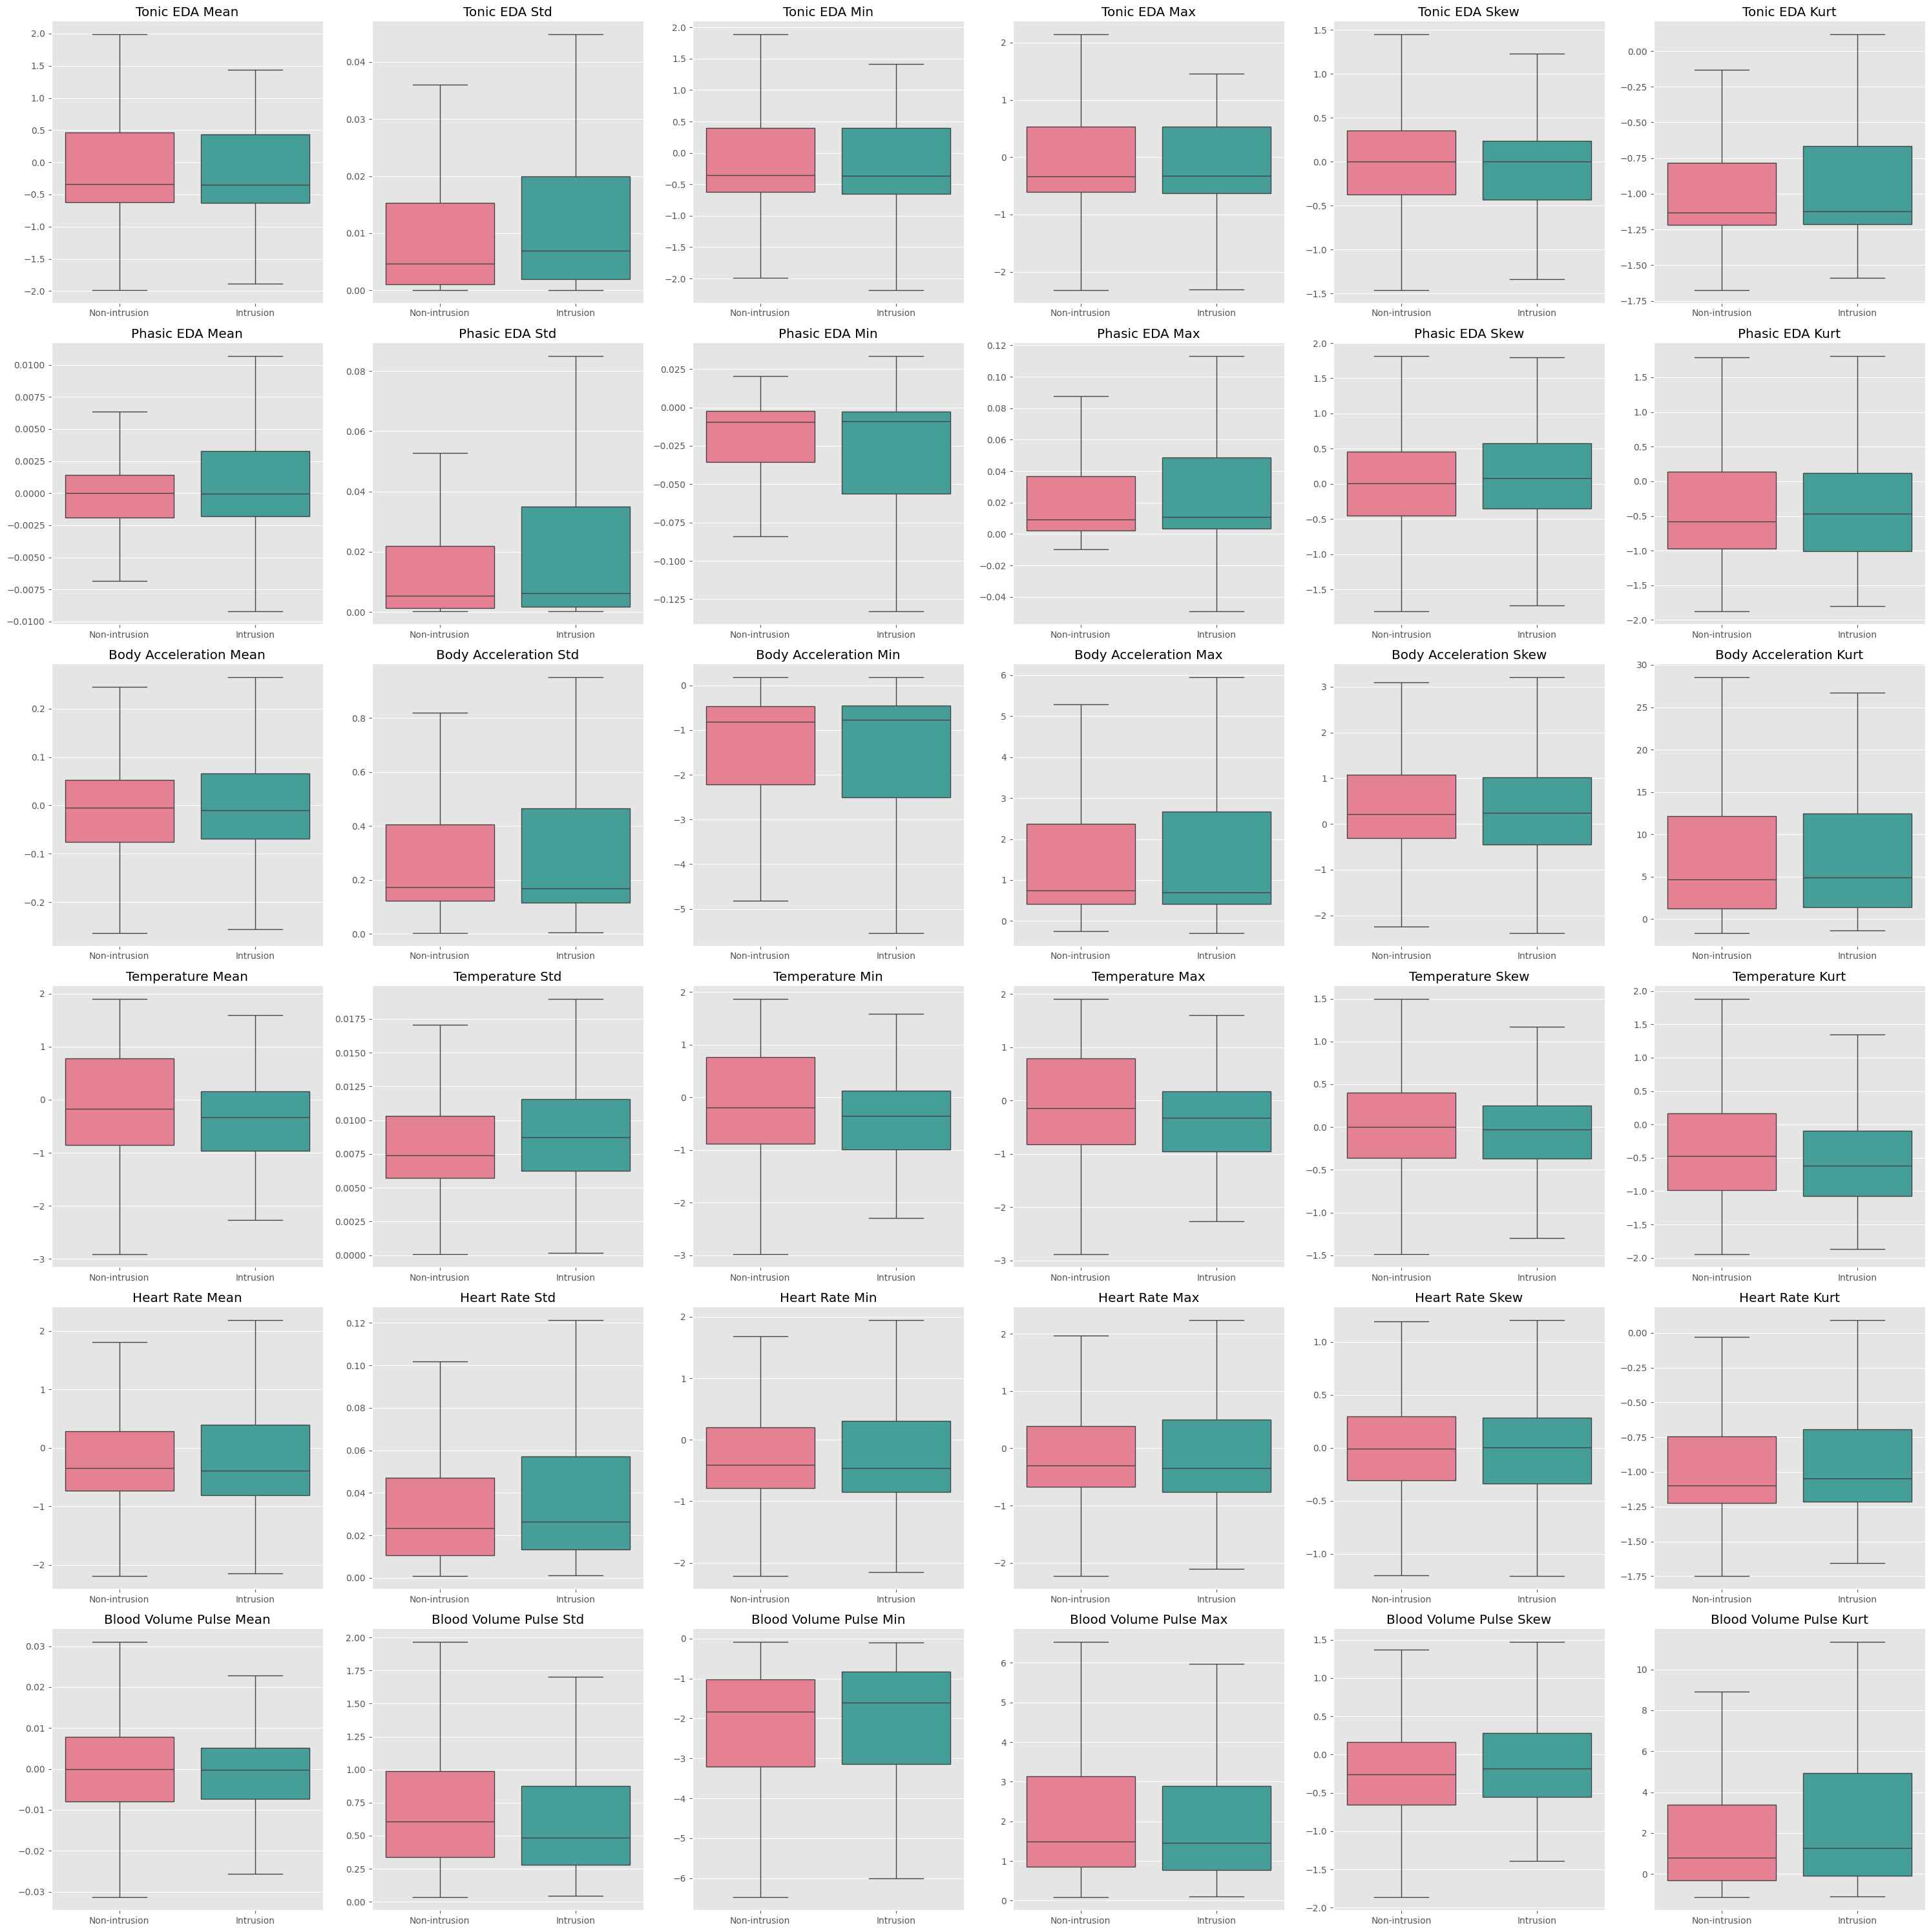

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of features
features = ['eda_tonic_mean', 'eda_tonic_std', 'eda_tonic_min', 'eda_tonic_max', 'eda_tonic_skew', 'eda_tonic_kurt', 
            'eda_phasic_mean', 'eda_phasic_std', 'eda_phasic_min', 'eda_phasic_max', 'eda_phasic_skew', 'eda_phasic_kurt', 
            'body_acc_mean', 'body_acc_std', 'body_acc_min', 'body_acc_max', 'body_acc_skew', 'body_acc_kurt', 
            'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_skew', 'temp_kurt', 
            'hr_mean', 'hr_std', 'hr_min', 'hr_max', 'hr_skew', 'hr_kurt', 
            'bvp_mean', 'bvp_std', 'bvp_min', 'bvp_max', 'bvp_skew', 'bvp_kurt']

title_dict = {
    'eda_tonic': 'Tonic EDA',
    'eda_phasic': 'Phasic EDA',
    'body_acc': 'Body Acceleration',
    'temp': 'Temperature',
    'hr': 'Heart Rate',
    'bvp': 'Blood Volume Pulse'
}

# Map features to titles
feature_titles = {feature: title_dict[feature.rsplit('_', 1)[0]] + ' ' + feature.rsplit('_', 1)[1].capitalize() for feature in features}

# Melt the DataFrame to "long-form" or "tidy" representation
df_melted = df.melt(id_vars='intrusion', value_vars=features)

# Create FacetGrid
g = sns.FacetGrid(df_melted, col="variable", col_wrap=6, sharex=False, sharey=False, height=5)
g.map(sns.boxplot, 'intrusion', 'value', showfliers=False, order=sorted(df['intrusion'].unique()), palette=sns.color_palette("husl", 2))

# Set the titles of the subplots
g.set_titles("{col_name}")
for ax in g.axes.flat:
    label = ax.get_title()
    ax.set_title(feature_titles[label])
    ax.set_xlabel('')  # Remove x-axis title
    ax.set_ylabel('')  # Remove y-axis title
    ax.set_xticklabels(['Non-intrusion', 'Intrusion'])  # Set x-axis tick labels

g.fig.tight_layout()
plt.show()

In [57]:
df.head()

,datetime,unix_time,source,trialcode,response,intrusion,participant,eda_tonic_mean,eda_tonic_std,eda_tonic_min,eda_tonic_max,eda_tonic_skew,eda_tonic_kurt,eda_phasic_mean,eda_phasic_std,eda_phasic_min,eda_phasic_max,eda_phasic_skew,eda_phasic_kurt,body_acc_mean,body_acc_std,body_acc_min,body_acc_max,body_acc_skew,body_acc_kurt,temp_mean,temp_std,temp_min,temp_max,temp_skew,temp_kurt,hr_mean,hr_std,hr_min,hr_max,hr_skew,hr_kurt,bvp_mean,bvp_std,bvp_min,bvp_max,bvp_skew,bvp_kurt
604226,2023-03-22 18:40:49.031250,1679510449.03,pp2-d2,TNT_NoThink_CSp,0,0.00,2,-0.63,0.00,-0.64,-0.63,-0.15,-1.25,0.00,0.00,-0.00,0.00,-0.23,-0.51,0.16,0.35,-2.21,1.37,-0.86,7.50,-0.34,0.00,-0.35,-0.34,-0.11,0.15,-0.69,0.00,-0.69,-0.68,0.91,0.11,-0.01,0.39,-1.29,0.69,-0.71,0.18
604227,2023-03-22 18:40:49.046875,1679510449.05,pp2-d2,TNT_NoThink_CSp,0,0.00,2,-0.63,0.00,-0.64,-0.63,-0.15,-1.25,0.00,0.00,-0.00,0.00,-0.23,-0.51,0.16,0.35,-2.21,1.37,-0.86,7.47,-0.34,0.00,-0.35,-0.34,-0.11,0.15,-0.69,0.00,-0.69,-0.68,0.90,0.08,-0.01,0.39,-1.29,0.69,-0.71,0.18
604900,2023-03-22 18:40:59.562500,1679510459.56,pp2-d2,TNT_Think_CSp,0,0.00,2,-0.63,0.00,-0.63,-0.63,-0.05,-1.23,-0.00,0.00,-0.00,0.00,-1.31,0.54,0.15,0.30,-1.21,1.27,-0.26,3.87,-0.34,0.00,-0.35,-0.33,-0.02,1.27,-0.68,0.01,-0.69,-0.67,-0.59,-1.11,0.00,0.53,-1.91,1.00,-0.85,0.75
604901,2023-03-22 18:40:59.578125,1679510459.58,pp2-d2,TNT_Think_CSp,0,0.00,2,-0.63,0.00,-0.63,-0.63,-0.05,-1.23,-0.00,0.00,-0.00,0.00,-1.31,0.54,0.15,0.30,-1.21,1.27,-0.26,3.88,-0.34,0.00,-0.35,-0.33,-0.01,1.27,-0.68,0.01,-0.69,-0.67,-0.59,-1.12,0.00,0.53,-1.91,1.00,-0.85,0.77
605510,2023-03-22 18:41:09.093750,1679510469.09,pp2-d2,TNT_Think_CSp,2,0.00,2,-0.63,0.00,-0.63,-0.63,-0.60,-1.15,0.00,0.00,-0.00,0.00,0.18,-0.81,0.12,0.29,-0.84,1.40,0.43,1.81,-0.33,0.00,-0.34,-0.32,0.02,-0.20,-0.65,0.02,-0.68,-0.62,-0.38,-1.07,-0.01,0.37,-1.07,0.76,-0.50,0.16
